In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here


{}

In [2]:
import os
import zipfile

# Make kaggle directory and move the json
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


# **Traffic Sign Classification Using Custom CNN**

In [ ]:
# Replace this with the Kaggle dataset identifier from the URL
DATASET_PATH = "meowmeowmeowmeowmeow/gtsrb-german-traffic-sign"

# Output folder in your Drive
OUTPUT_DIR = "/content/drive/MyDrive/GTSRB_Dataset"

# Download and unzip
!kaggle datasets download -d {DATASET_PATH} -p {OUTPUT_DIR}
!unzip -q "{OUTPUT_DIR}/*.zip" -d {OUTPUT_DIR}


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100% 609M/612M [00:03<00:00, 166MB/s]
100% 612M/612M [00:03<00:00, 173MB/s]


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
# Paths
data_dir = '/content/drive/MyDrive/GTSRB_Dataset'
train_path = os.path.join(data_dir, 'Train')
test_csv_path = os.path.join(data_dir, 'Test.csv')

# Image Dimensions
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

# Number of Classes
NUM_CATEGORIES = 43

/tmp/ipython-input-1191996225.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Image_Count', data=data, palette='viridis')


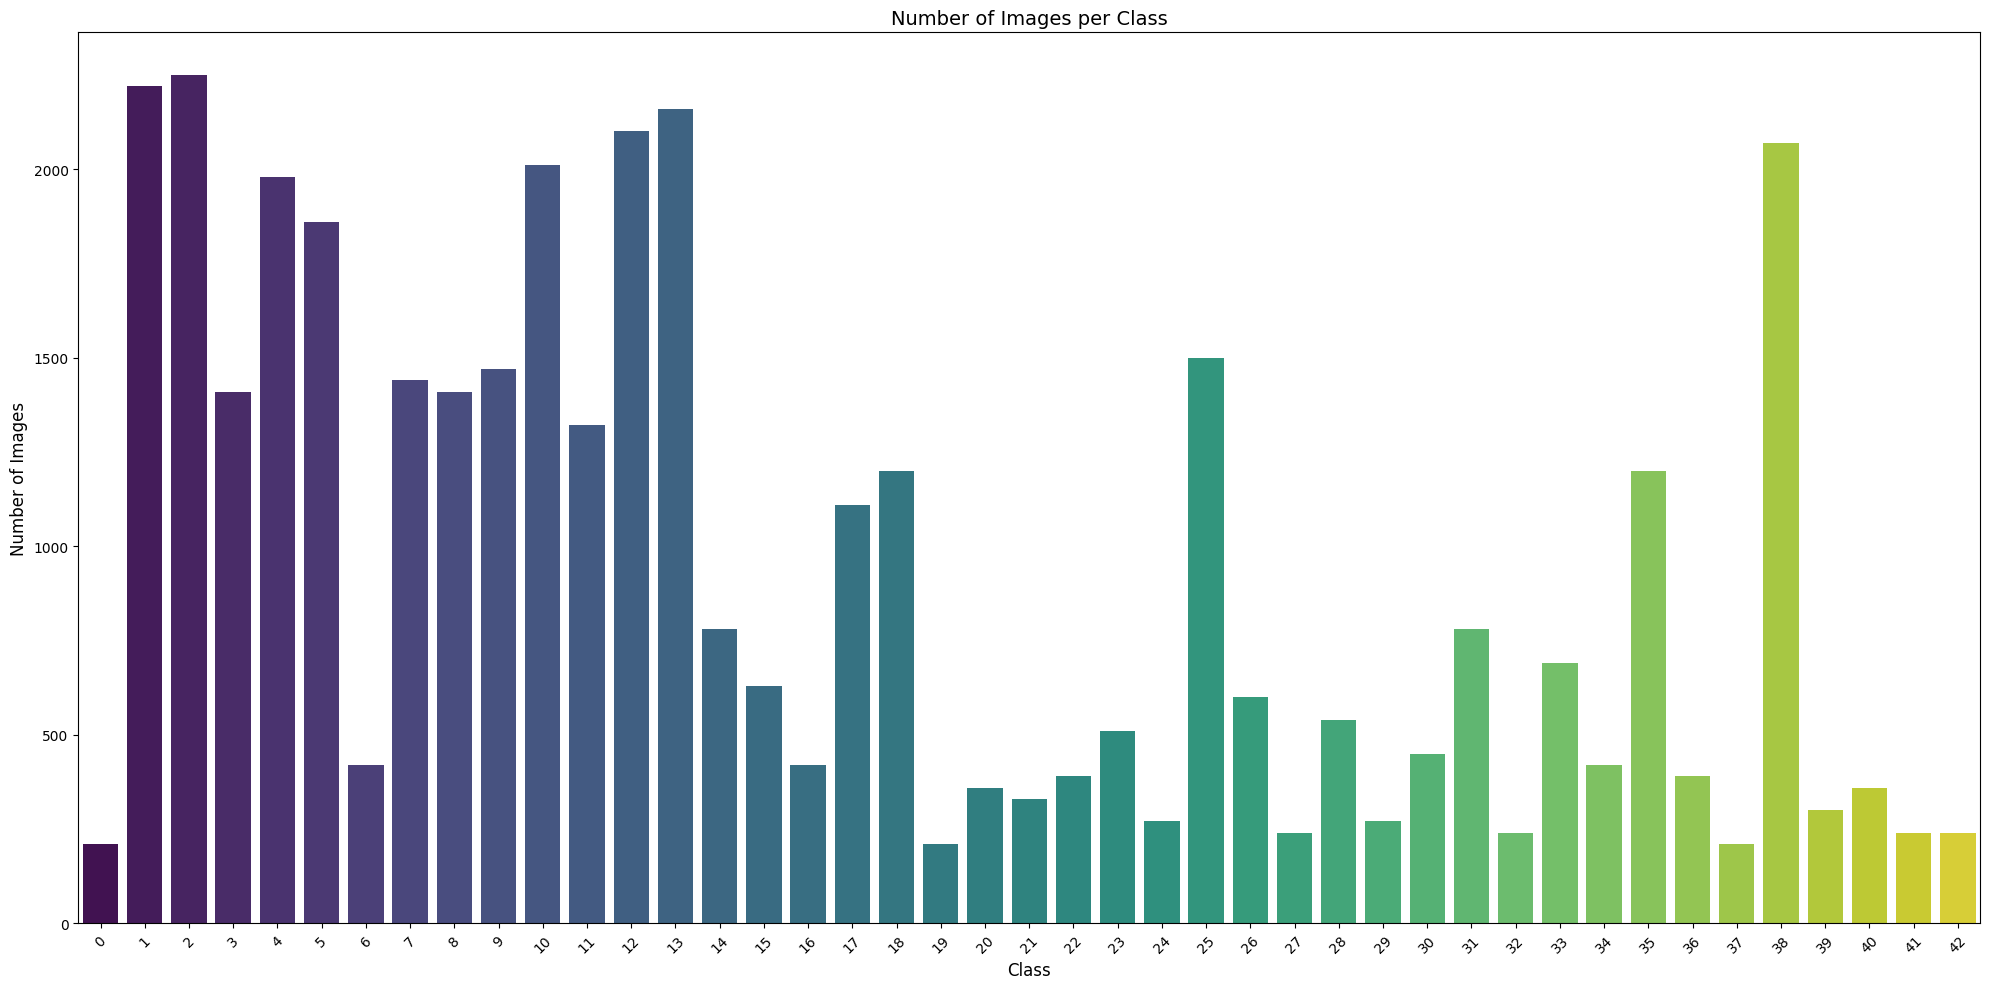

In [5]:
# Class image count per folder
classes = []
image_counts = []

for i in range(NUM_CATEGORIES):
    class_path = os.path.join(train_path, str(i))
    images = os.listdir(class_path)
    classes.append(i)
    image_counts.append(len(images))

data = pd.DataFrame({'Class': classes, 'Image_Count': image_counts})

# Bar plot
plt.figure(figsize=(20, 10))
sns.barplot(x='Class', y='Image_Count', data=data, palette='viridis')
plt.title('Number of Images per Class', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = os.path.join(train_path, str(i))
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(os.path.join(path, img))
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in:", img)

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print("Data shape:", image_data.shape, image_labels.shape)

/tmp/ipython-input-1758960979.py:11: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')


Data shape: (39209, 30, 30, 3) (39209,)


In [8]:
# Shuffle data
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)

image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    image_data, image_labels, test_size=0.3, random_state=42, shuffle=True
)

# Normalize
X_train = X_train / 255.0
X_val = X_val / 255.0

# One-hot encode labels
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (27446, 30, 30, 3)
X_val shape: (11763, 30, 30, 3)
y_train shape: (27446, 43)
y_val shape: (11763, 43)


In [ ]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(NUM_CATEGORIES, activation='softmax')
])

lr = 0.001
epochs = 30
opt = Adam(learning_rate=lr)


model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,171,275 (4.47 MB)

 Trainable params: 1,169,931 (4.46 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

history = model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    epochs=epochs,
    validation_data=(X_val, y_val)
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.5291 - loss: 1.9221 - val_accuracy: 0.9770 - val_loss: 0.0826
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9310 - loss: 0.2219 - val_accuracy: 0.9849 - val_loss: 0.0493
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9622 - loss: 0.1201 - val_accuracy: 0.9579 - val_loss: 0.1338
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9683 - loss: 0.1022 - val_accuracy: 0.9957 - val_loss: 0.0161
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.9718 - loss: 0.0838 - val_accuracy: 0.9855 - val_loss: 0.0524
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9785 - loss: 0.0725 - val_accuracy: 0.9861 - val_loss: 0.0473
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9744 - loss: 0.0791 - val_accuracy: 0.9849 - val_loss: 0.0501
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9846 - loss: 0.0485 - val_accurac

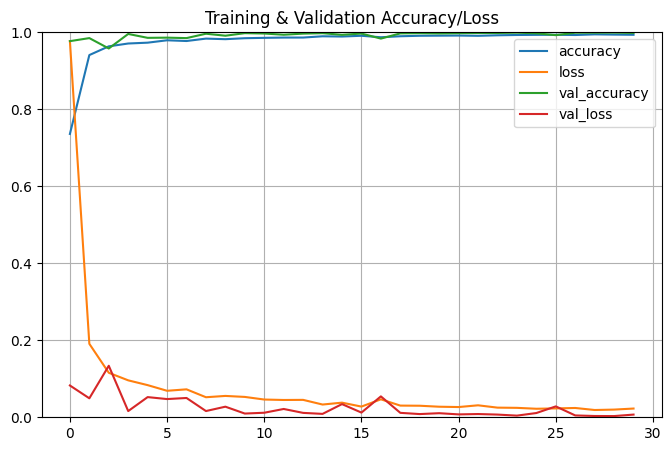

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1)
plt.title("Training & Validation Accuracy/Loss")
plt.show()

In [ ]:
test = pd.read_csv(test_csv_path)
labels = test["ClassId"].values
imgs = test["Path"].values

test_data = []

for img in imgs:
    try:
        image = cv2.imread(os.path.join(data_dir, img))
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        test_data.append(np.array(resize_image))
    except:
        print("Error in:", img)

X_test = np.array(test_data) / 255.0


/tmp/ipython-input-945013735.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Test Accuracy: 98.11559778305622


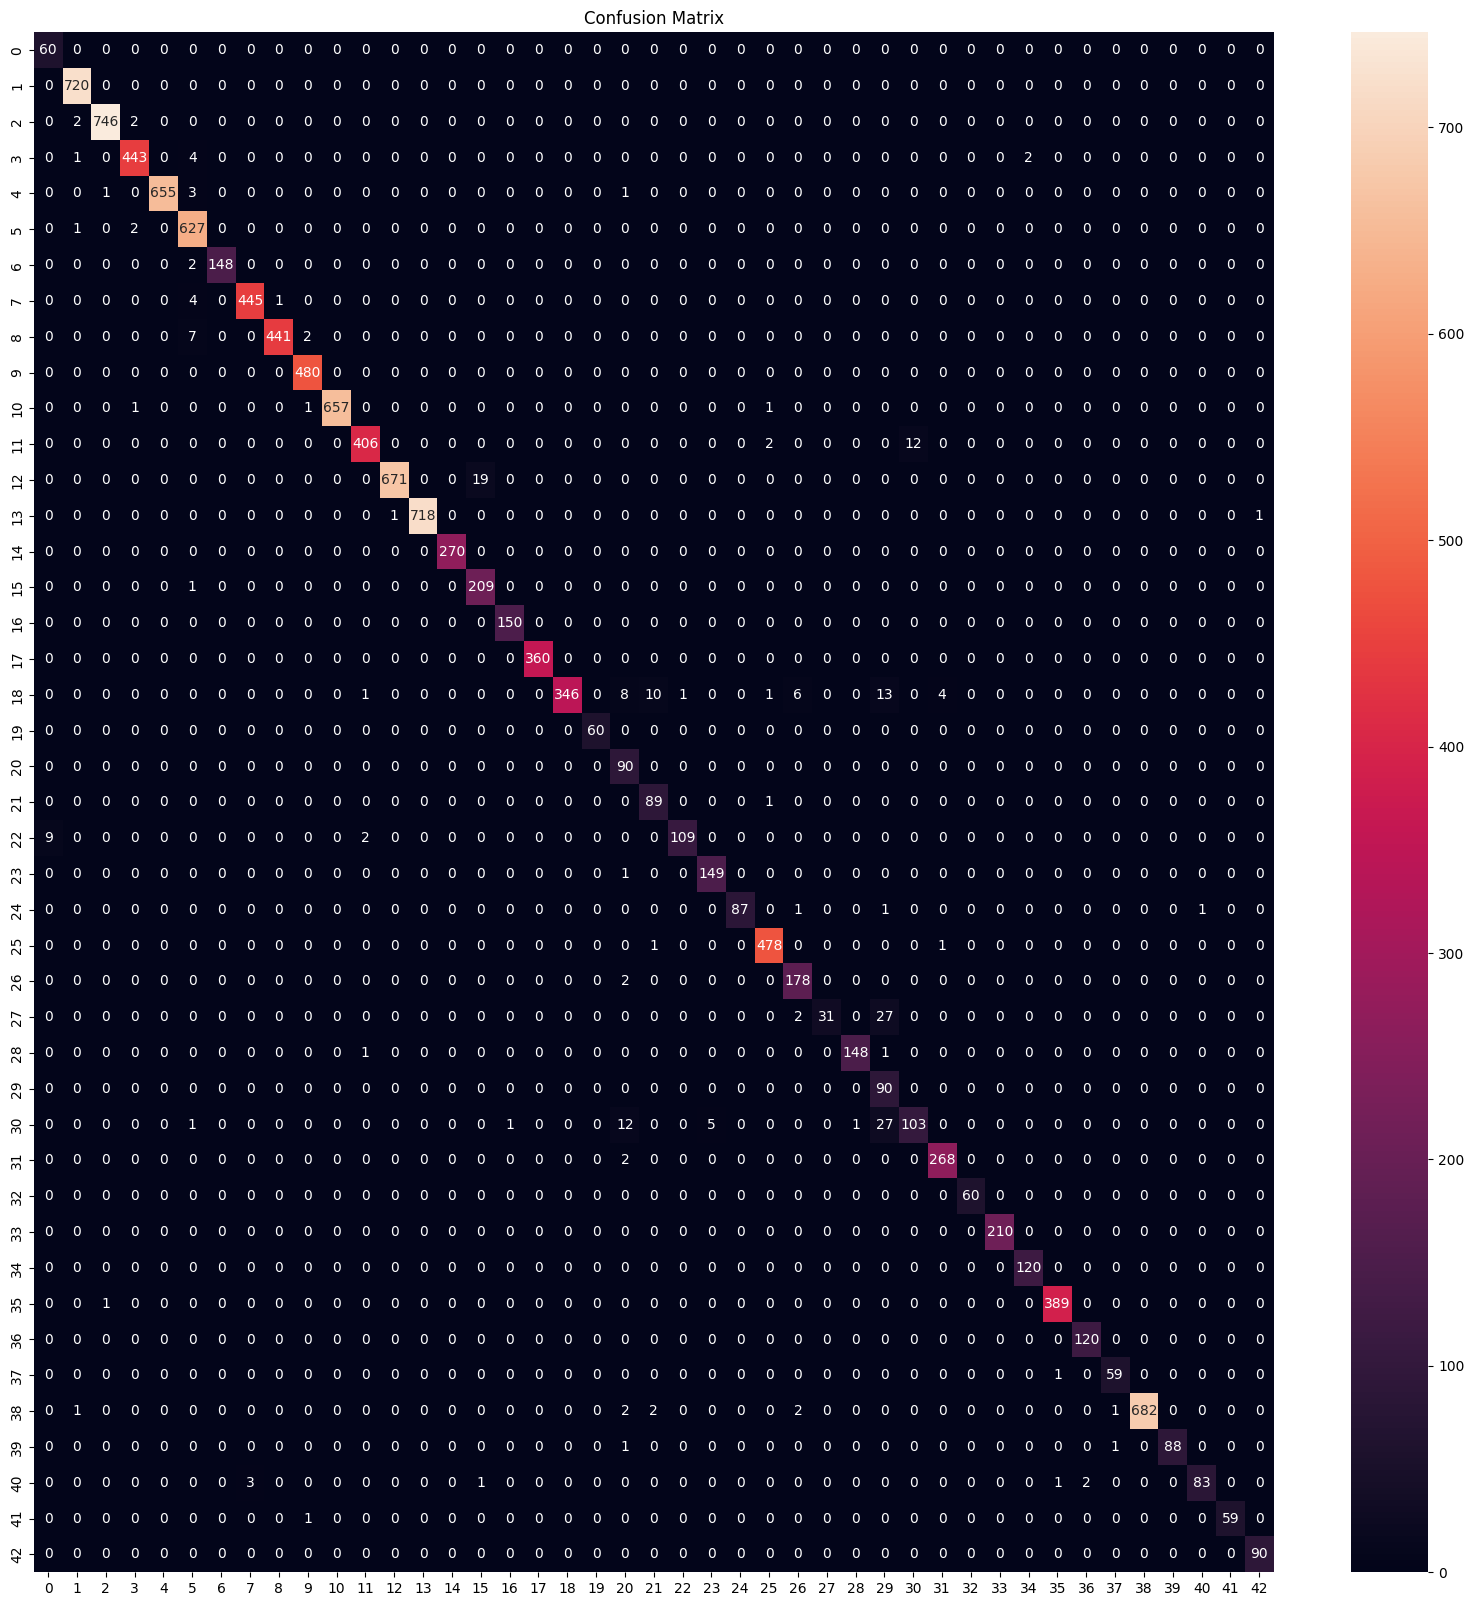

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        60
           1       0.99      1.00      1.00       720
           2       1.00      0.99      1.00       750
           3       0.99      0.98      0.99       450
           4       1.00      0.99      1.00       660
           5       0.97      1.00      0.98       630
           6       1.00      0.99      0.99       150
           7       0.99      0.99      0.99       450
           8       1.00      0.98      0.99       450
           9       0.99      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.97      0.98       420
          12       1.00      0.97      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.91      1.00      0.95       210
          16       0.99      1.00      1.00       150
          17       1.00    

In [ ]:
# Get predictions
pred = np.argmax(model.predict(X_test), axis=1)

# Accuracy
print('Test Accuracy:', accuracy_score(labels, pred) * 100)

# Confusion Matrix
cf = confusion_matrix(labels, pred)
df_cm = pd.DataFrame(cf, index=range(NUM_CATEGORIES), columns=range(NUM_CATEGORIES))
plt.figure(figsize=(20, 20))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(labels, pred))


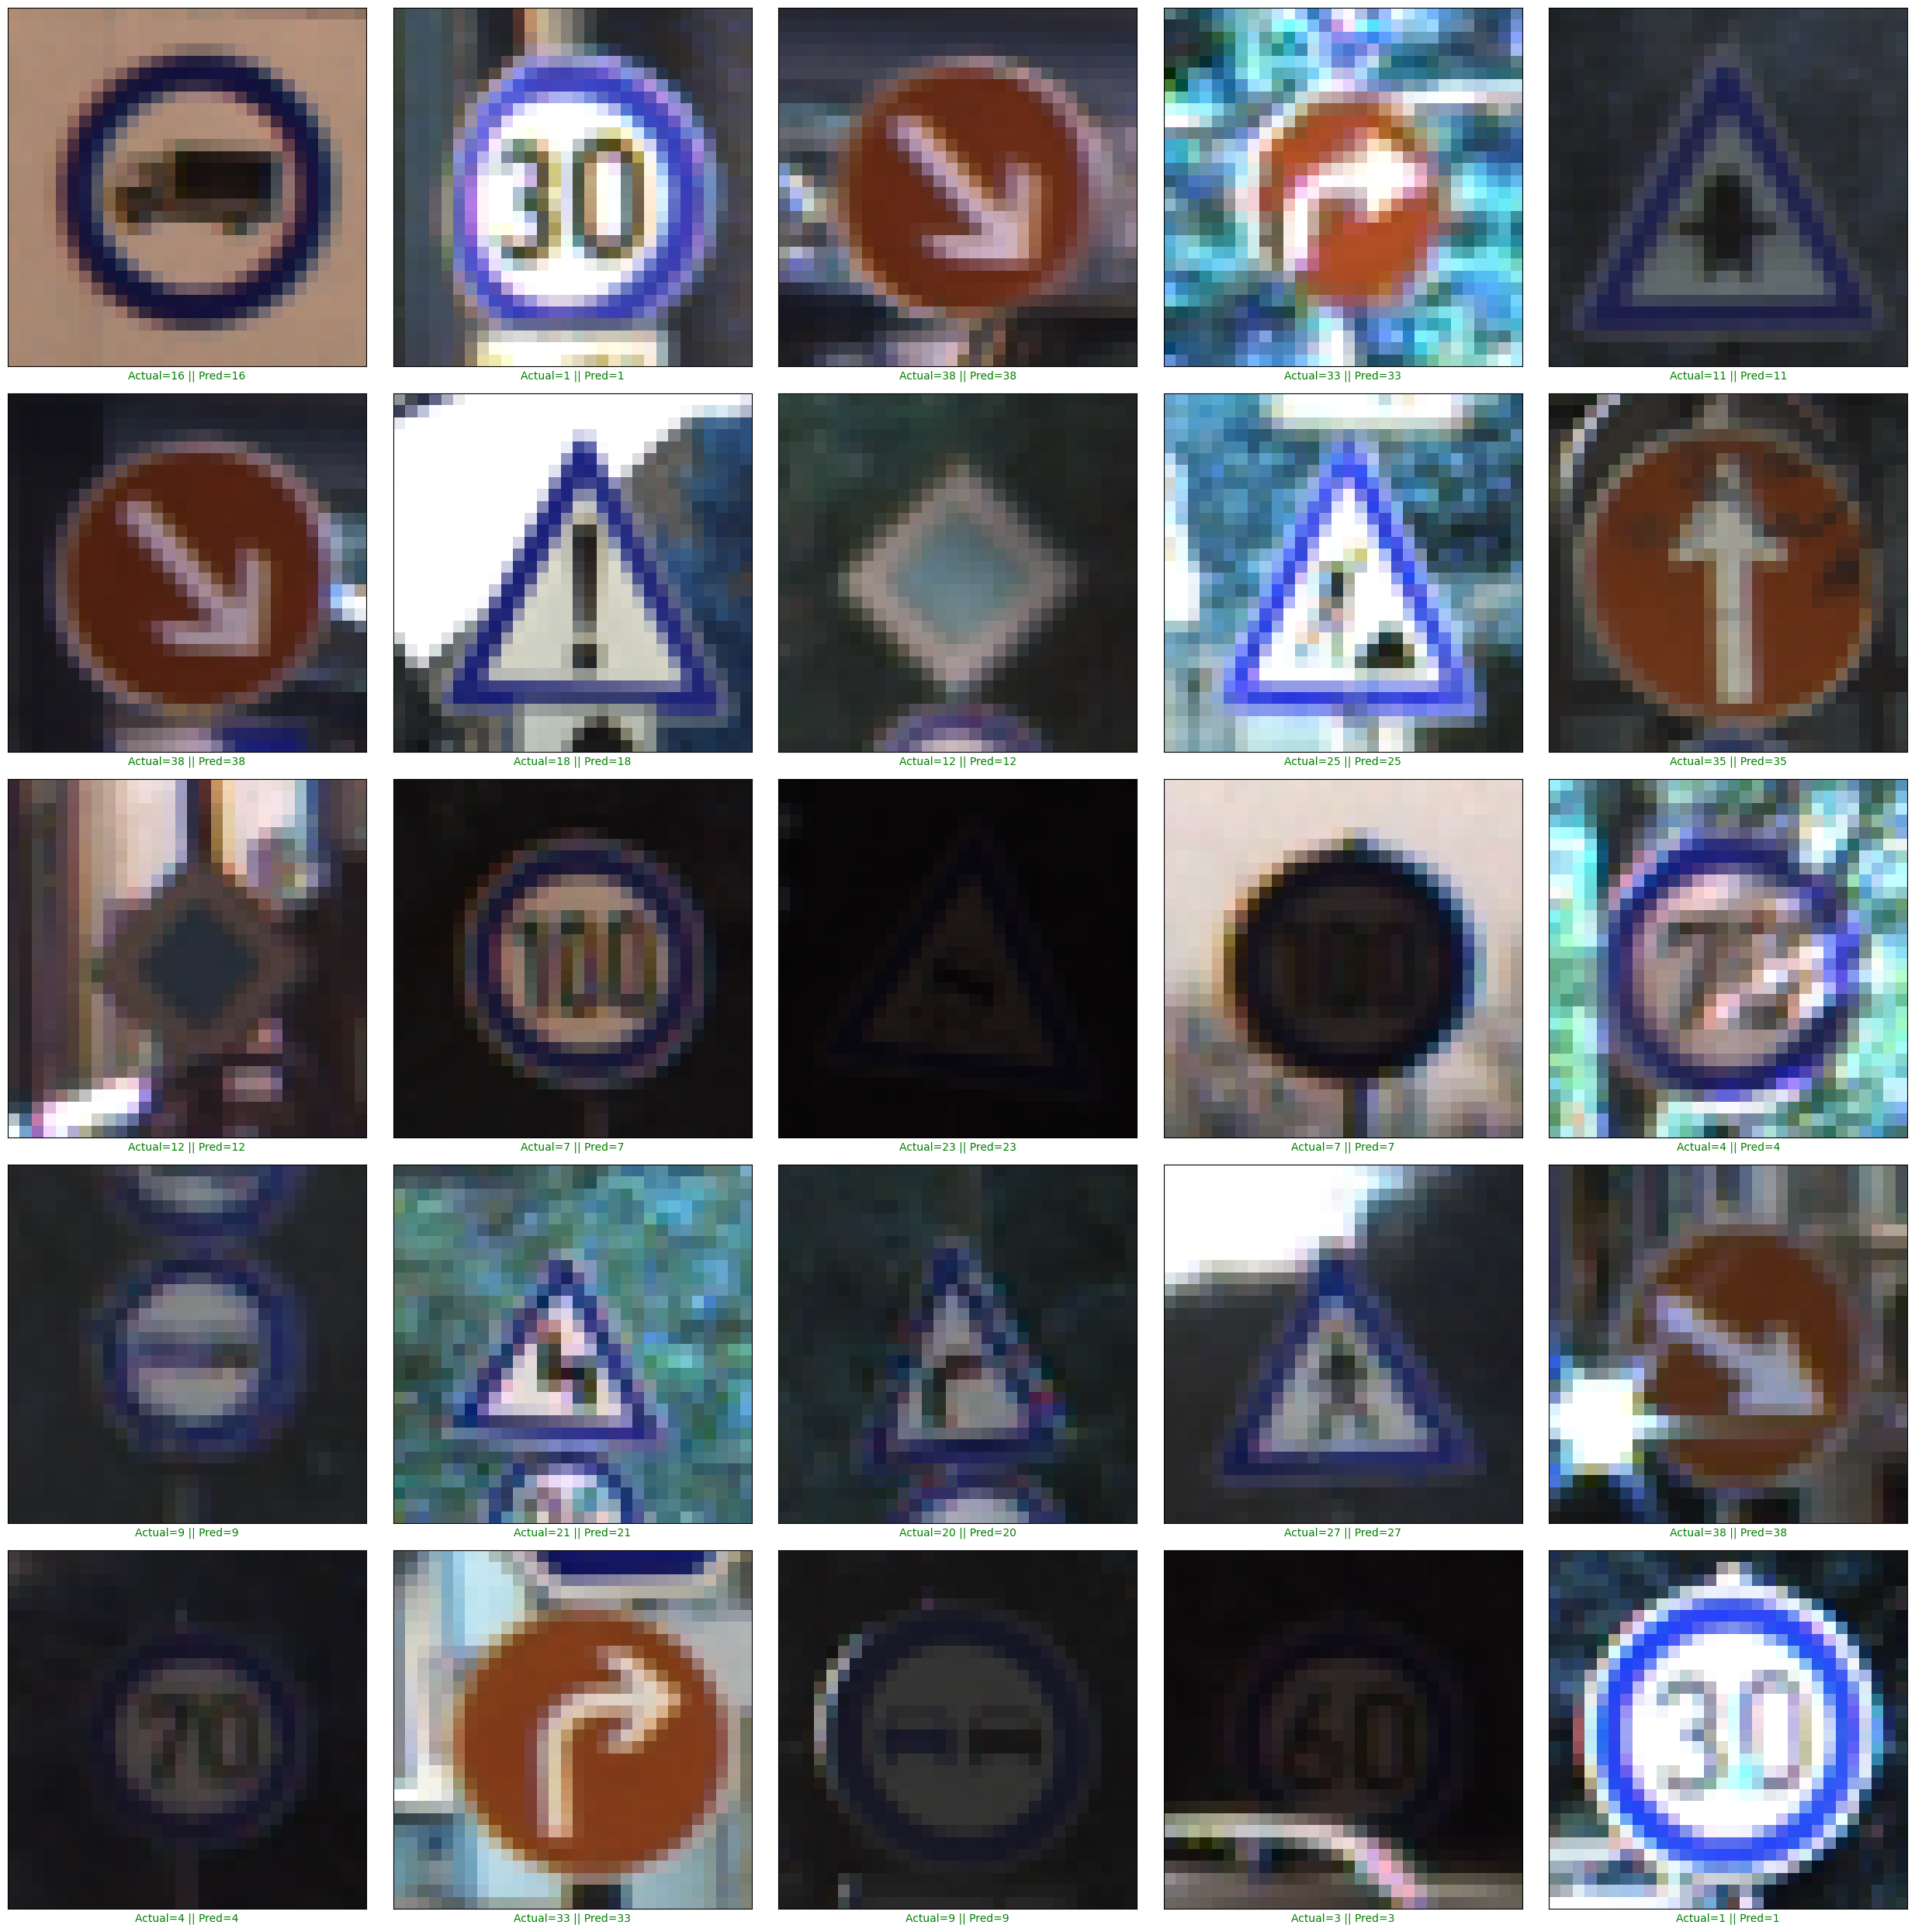

In [ ]:
plt.figure(figsize=(25, 25))
start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g' if prediction == actual else 'r'
    plt.xlabel(f'Actual={actual} || Pred={prediction}', color=col)
    plt.imshow(X_test[start_index + i])
plt.tight_layout()
plt.show()


# **Using MobilenetV2**

In [11]:
import cv2
X_train_resized = np.array([cv2.resize(img, (64, 64)) for img in X_train])
X_val_resized = np.array([cv2.resize(img, (64, 64)) for img in X_val])


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

IMG_HEIGHT, IMG_WIDTH = 64, 64  # your resized shape
NUM_CATEGORIES = 43  # number of traffic sign classes

base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x)

model_mobile = Model(inputs=base_model.input, outputs=predictions)
model_mobile.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model_mobile.summary()


/tmp/ipython-input-950534087.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 2,393,387 (9.13 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Data augmentation (same as custom CNN)
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Early stopping (optional)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Train
history_mobile = model_mobile.fit(
    datagen.flow(X_train_resized, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val_resized, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 123s 89ms/step - accuracy: 0.4711 - loss: 2.0438 - val_accuracy: 0.3559 - val_loss: 5.7937
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.8953 - loss: 0.3891 - val_accuracy: 0.7162 - val_loss: 1.8025
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.9409 - loss: 0.2320 - val_accuracy: 0.8559 - val_loss: 0.8213
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.9581 - loss: 0.1761 - val_accuracy: 0.7928 - val_loss: 1.4312
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.9655 - loss: 0.1406 - val_accuracy: 0.6759 - val_loss: 4.3072
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.9696 - loss: 0.1244 - val_accuracy: 0.8806 - val_loss: 0.6825
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.9690 - loss: 0.1286 - val_accuracy: 0.9452 - val_loss: 0.2914
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 80s 51ms/step - accuracy: 0.9738 - loss: 0.1169 -

368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
✅ MobileNetV2 Test Accuracy: 94.52 %


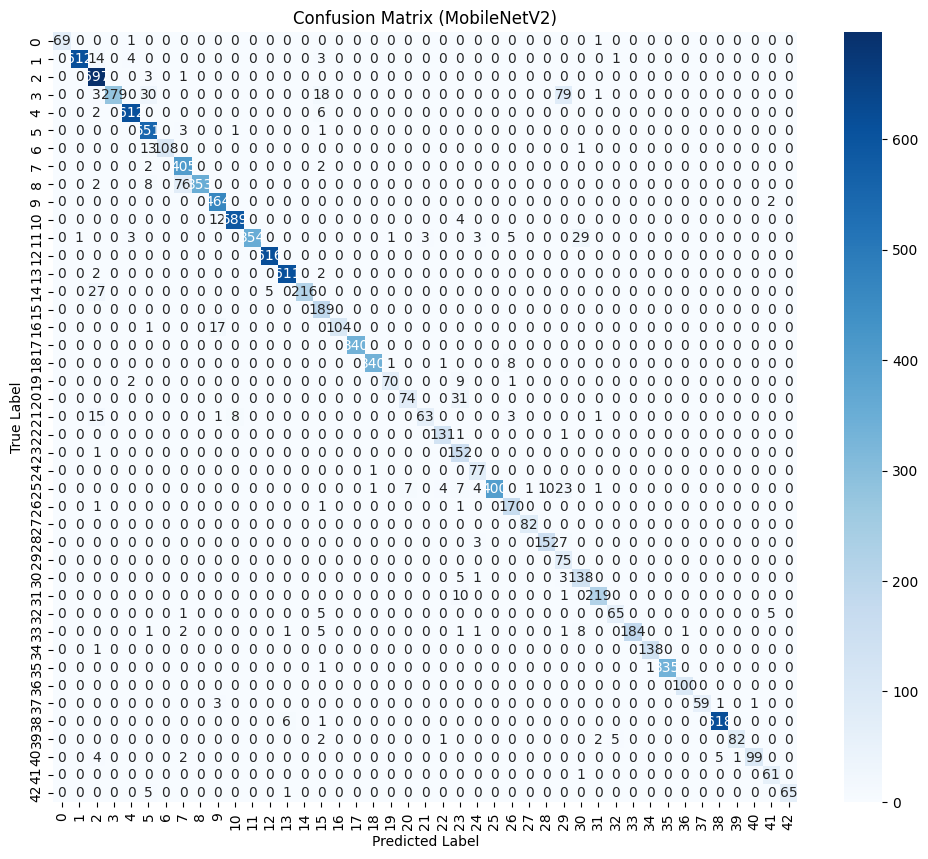

In [19]:
# Predict
X_test = X_val_resized
y_test = np.argmax(y_val, axis=1)  # convert from one-hot to label

pred_mobile = model_mobile.predict(X_test)
pred_classes_mobile = np.argmax(pred_mobile, axis=1)

# Accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
acc_mobile = accuracy_score(y_test, pred_classes_mobile)
print("✅ MobileNetV2 Test Accuracy:", round(acc_mobile * 100, 2), "%")

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cf_mobile = confusion_matrix(y_test, pred_classes_mobile)

plt.figure(figsize=(12, 10))
sns.heatmap(cf_mobile, annot=True, fmt='d', cmap='Blues')  # <- annot=True, fmt='d'
plt.title("Confusion Matrix (MobileNetV2)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


**Conclusion:**

The custom CNN model outperformed MobileNetV2 on the GTSRB dataset.

 Custom CNN Accuracy: 98%

 MobileNetV2 Accuracy: 94%

   This shows that the custom model is better suited for this specific traffic sign classification task, possibly due to being simpler and more tailored to the dataset, while MobileNetV2 may have underperformed due to resizing or being too generalized.